<img width="60px" style="float: right;" src="https://xmks.s3.amazonaws.com/2020/X-Blue.png">

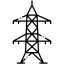
# Power Grid: Create a model that can be used for simulation as well as real-time monitoring for grid load

## Importing Necessary Libraries

Firstly, we need to import all the necessary libraries that will be used throughout the code.

The libraries include `pypsa` for power system simulations, `numpy` and `pandas` for numerical calculations and data manipulation, `json` for handling JSON data, `requests` and `urllib.parse` for making HTTP requests, and `functools` for higher-order functions and operations on callable objects. Lastly, we import `mlflow` for Machine Learning Lifecycle management.


In [1]:
!pip install pypsa --quiet
import pypsa
import numpy as np
import pandas as pd
import json
import requests
import urllib.parse
from functools import reduce
import requests
import mlflow
import mlflow.pyfunc

# Create Network

Next, we define a function named `powerflow_analysis` that will take input as data and perform power flow analysis using the PyPSA library. 

This function creates a network of buses, loads, generators, and lines based on the input data. The power flow analysis is then performed on this network. The result of the analysis is a dictionary of calculated metrics, which are returned as a GeoJSON string.


In [2]:
def powerflow_analysis(data):
    
    data = str(data['input'].values[0])
    
    # Load the data string as a json
    data = json.loads(data)
    
    # Print the data for debugging purposes
    print(data)
    
    # Create a new Network object
    network = pypsa.Network()

    # Add buses and loads to the network from the data
    for item in data['features']:
        if item['properties']['type']=='Bus':
            network.add("Bus", 
                        item['properties']['Id'], 
                        v_nom=item['properties']['BaseKV'],
                        x=item['geometry']['coordinates'][0],
                        y=item['geometry']['coordinates'][1],
                        control=item['properties']['Bus Type'])
            
            # Adding loads to the network
            network.add("Load",
                        f"Load{item['properties']['Id']}",
                        bus=item['properties']['Id'],
                        p_set=item['properties']['MW Load'])

    # Add generators to the network from the data
    for item in data['features']:
        if item['properties']['type']=='Generator':
            network.add("Generator", 
                        item['properties']['Id'],
                        bus=item['properties']['Bus ID'],
                        p_set=item['properties']['MW Inj'],
                        control="PQ")

    # Add lines to the network from the data
    for item in data['features']:
        if item['properties']['type']=='Line':
            network.add(
                "Line",
                item['properties']['Id'],
                bus0=item['properties']['From Bus'],
                bus1=item['properties']['To Bus'],
                x=item['properties']['X'],
                r=item['properties']['R'])
            
    # Run Power Flow Analysis on the network
    network.pf()
    
    # Build metrics for lines, buses, and generators
    _dfs_lines = []
    _dfs_buses = []
    _dfs_generators = []

    for k, v in network.lines_t.items():
        _df = v.melt(ignore_index=False).reset_index().iloc[:,1:]
        _df = _df.rename(columns={_df.columns[-1]: k})
        _dfs_lines.append(_df)

    for k, v in network.buses_t.items():
        _df = v.melt(ignore_index=False).reset_index().iloc[:,1:]
        _df = _df.rename(columns={_df.columns[-1]: k})
        _dfs_buses.append(_df)

    for k, v in network.generators_t.items():
        _df = v.melt(ignore_index=False).reset_index().iloc[:,1:]
        _df = _df.rename(columns={_df.columns[-1]: k})
        _dfs_generators.append(_df)
        
    # Combine all metrics dataframe for lines
    df_lines = reduce(lambda left,right: pd.DataFrame.combine_first(left,right), _dfs_lines)
    df_lines = df_lines.set_index('variable')
    df_lines = df_lines.dropna(axis=1, how='all').T.to_dict()
    
    # Combine all metrics dataframe for buses
    df_buses = reduce(lambda left,right: pd.DataFrame.combine_first(left,right), _dfs_buses)
    df_buses = df_buses.set_index('Bus')
    df_buses = df_buses.dropna(axis=1, how='all').T.to_dict()
    
    # Combine all metrics dataframe for generators
    df_generators = reduce(lambda left,right: pd.DataFrame.combine_first(left,right), _dfs_generators)
    df_generators = df_generators.set_index('Generator')
    df_generators = df_generators.dropna(axis=1, how='all').T.to_dict()
    
    # Update Data with the power flow analysis results
    for item in data['features']:
        _id = item['properties']['Id']
        if _id in df_lines:
            _addin = df_lines[_id]
            item['properties'].update(_addin)

        if _id in df_buses:
            _addin = df_buses[_id]
            item['properties'].update(_addin)

        if _id in df_generators:
            _addin = df_generators[_id]
            item['properties'].update(_addin)
    
    # Return the updated data as a list of json objects - this is required for the MLFlow response
    return [json.dumps(data)]
        

# Model Deployment

In the following code block, we save and deploy our model using `mlflow`.

We first define a model signature that defines the input and output data schema for our model. Then we create a subclass of `mlflow.pyfunc.PythonModel` where we override the `predict` function.

We then specify the MLFlow tracking URI and start a new MLFlow run. The model is logged to this run and then registered in MLFlow's model registry.



<div class="alert alert-block alert-info">
    <b>NOTE:</b> Set the specific IP address and port for your MLFlow server</div>

In [33]:
# Importing necessary libraries
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema
import mlflow
from mlflow import pyfunc

# Define a schema for the input and output of your model
# In this case, both input and output are single columns of string type
sig = ModelSignature(
        inputs=Schema([ColSpec(name="input", type="string")]),
        outputs=Schema([ColSpec(name="output", type="string")]),
    )

# Define a new class that inherits from mlflow.pyfunc.PythonModel
# This is necessary to define the predict function for your model
class PowerFlowModel(mlflow.pyfunc.PythonModel):
    def predict(self, context, model_input):
        # Call the powerflow_analysis function defined earlier to predict on the model_input
        return powerflow_analysis(model_input)

# Set the tracking URI for MLflow
# This is the address where the MLflow server is running
# Replace the IP address and port number with the ones for your server
mlflow.set_tracking_uri('http://IPADDRESS:5000')

# Start a new MLflow run
# This represents a single execution of the model training code
with mlflow.start_run():

    # Specify the model path
    model_path = "model"
    
    # Log the model
    # This saves the model in a format that can be loaded later for further use
    # 'python_model' specifies the Python model to log
    # 'signature' specifies the input and output schema of the model
    mlflow.pyfunc.log_model(
        model_path,
        python_model=PowerFlowModel(),
        signature=sig
    )

    # Register the model in MLflow's model registry
    # This makes the model easily accessible from anywhere in the MLflow environment
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_path}"
    registered_model_name = "PowerFlowAnalysis"
    mlflow.register_model(model_uri, registered_model_name)



Registered model 'PowerFlowAnalysis_5b' already exists. Creating a new version of this model...
2023/07/13 04:21:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: PowerFlowAnalysis_5b, version 11
Created version '11' of model 'PowerFlowAnalysis_5b'.
